**Introduction**
The following document includes key visuals from the Trees dataset from the FIA some analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style("whitegrid")

#### **Looking at Measurement/Inventory times to Figure out how long before each tree measurement**
Here I am looking at when trees were taken inventory of.  I unzipped the WA_TREE.csv into the data folder.  On github it will still be zipped.  

In [42]:
WT = pd.read_csv('../Data/WA_TREE.csv')
WT.info()

/var/folders/rd/2pn3c7gx2_9_cbdrsq0k0r6r0000gn/T/ipykernel_63441/2615639649.py:1: DtypeWarning:

Columns (77,159) have mixed types. Specify dtype option on import or set low_memory=False.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504956 entries, 0 to 504955
Columns: 197 entries, CN to PREV_HT_FLD
dtypes: float64(180), int64(13), object(4)
memory usage: 758.9+ MB


In [43]:
WT.sample(2)

CN           PLT_CN   PREV_TRE_CN  INVYR  STATECD  \
112938    8635941010901    8635925010901           NaN   2006       53   
381150  504415168126144  412222096489998  2.325101e+13   2017       53   

        UNITCD  COUNTYCD   PLOT  SUBP  TREE  ...  VOLCSNET_BARK  DRYBIO_STEM  \
112938       7        59  57727     1   304  ...      21.861225  4026.969058   
381150       7        41  53769     1   328  ...            NaN          NaN   

        DRYBIO_STEM_BARK  DRYBIO_STUMP_BARK  DRYBIO_BOLE_BARK  DRYBIO_BRANCH  \
112938        470.315702          12.310038        457.377341      861.06773   
381150               NaN                NaN               NaN            NaN   

        DRYBIO_FOLIAGE  DRYBIO_SAWLOG_BARK  PREV_ACTUALHT_FLD  PREV_HT_FLD  
112938      232.018567          453.702127                NaN          NaN  
381150             NaN                 NaN                NaN          NaN  

[2 rows x 197 columns]

In [44]:
WT['PLT_CN'].nunique()
WT['CN']

0                  4871760
1                  4871761
2                  4879506
3                  4871762
4                  4871763
                ...       
504951    1287253101290487
504952    1287253102290487
504953    1287253103290487
504954    1287253104290487
504955    1287253105290487
Name: CN, Length: 504956, dtype: int64

This code combines the two years that one tree was measured along with the plot number that the tree sits in.  

In [5]:
years = np.zeros((len(WT),3))
for index,row in WT.iterrows():
    if not np.isnan(row.PREV_TRE_CN) and (row.INVYR != 0):
        oldrow = WT[WT['CN'] == row.PREV_TRE_CN]
        if not oldrow.empty:
            years[index,0] = oldrow.iloc[0].INVYR	
            years[index,1] = row.INVYR	
            years[index,2] = row.PLOT

years.shape

(504956, 3)

Getting rid of zeros.

(221447, 3)


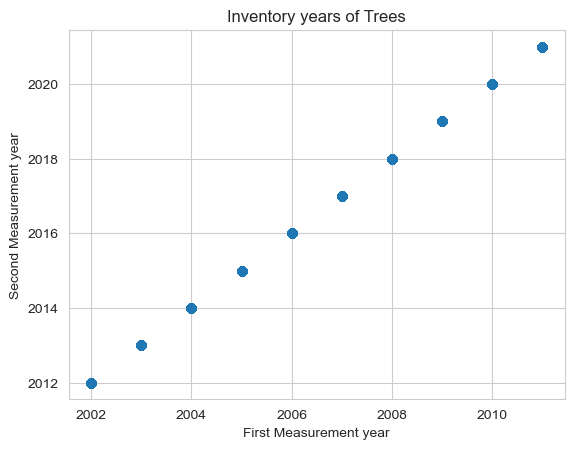

In [20]:
zeros = np.any(years == 0, axis = 1)
years = years[~zeros]
print(years.shape)
plt.scatter(years[:,0],years[:,1])
plt.title('Inventory years of Trees')
plt.xlabel('First Measurement year')
plt.ylabel('Second Measurement year')
plt.show()

This graph is showing that the inventory was taken every 10 years in waves of 2 years! -- very consistent 
Also notice that getting rid of the zeros in the dataset reduced the years table by half which would make sense if most of the trees were measured twice!

In [8]:
yearsdf = pd.DataFrame(years,columns = ['INVYR1','INVYR2','PLOT'])

PLOT = pd.read_csv('../Data/WA_PLOT.csv')
PLOT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 69 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CN                              22083 non-null  int64  
 1   SRV_CN                          22083 non-null  int64  
 2   CTY_CN                          22083 non-null  int64  
 3   PREV_PLT_CN                     9844 non-null   float64
 4   INVYR                           22083 non-null  int64  
 5   STATECD                         22083 non-null  int64  
 6   UNITCD                          22083 non-null  int64  
 7   COUNTYCD                        22083 non-null  int64  
 8   PLOT                            22083 non-null  int64  
 9   PLOT_STATUS_CD                  22083 non-null  int64  
 10  PLOT_NONSAMPLE_REASN_CD         979 non-null    float64
 11  MEASYEAR                        22083 non-null  int64  
 12  MEASMON                         

In [9]:
TREEPLOTS = PLOT[PLOT['PLOT'].isin(yearsdf['PLOT'])]

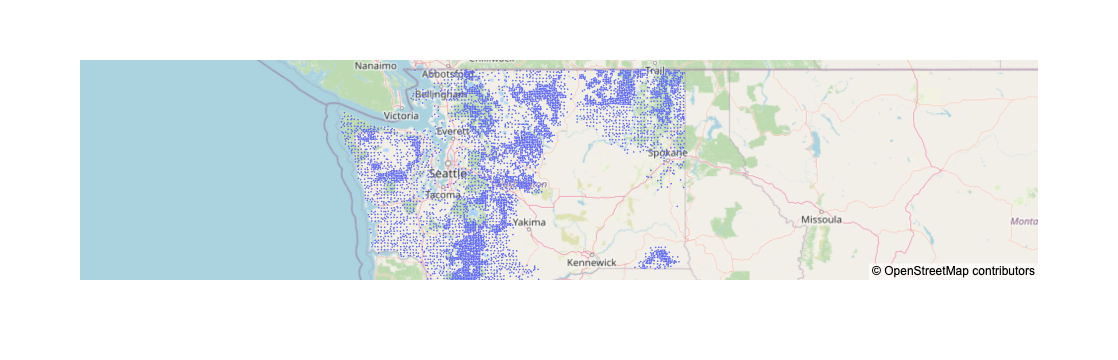

In [10]:
fig = px.scatter_mapbox(TREEPLOTS, lat='LAT', lon='LON',zoom=5,mapbox_style="open-street-map")

fig.update_traces(marker = dict(size = 2))

fig.update_layout(
    mapbox_center={"lat": 47.5, "lon": -120.0},  # Center on Washington
)

fig.show()

Conclusion: These are the plots where these trees that have been measured multiple times are located. We have 221447 trees that have been measured multiple times in a wide geographic range of plots. This is great.

Now going to add measurement dates to the years table from the plot csv to see if the inventory years are actually accurate. 

In [12]:
years_PLOT = np.zeros((len(PLOT),3))
for index,row in PLOT.iterrows():
    if not np.isnan(row.PREV_PLT_CN) and (row.MEASYEAR != 0):
        oldrow = PLOT[PLOT['CN'] == row.PREV_PLT_CN]
        if not oldrow.empty:
            years_PLOT[index,0] = oldrow.iloc[0].MEASYEAR	
            years_PLOT[index,1] = row.MEASYEAR	
            years_PLOT[index,2] = row.PLOT

years.shape

(221447, 3)

(9594, 3)


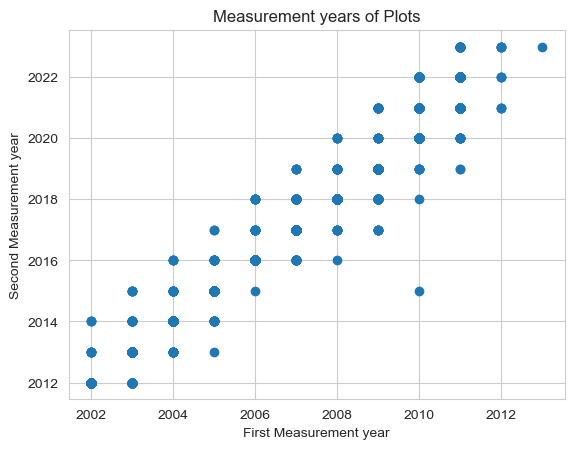

In [22]:
zeros = np.any(years_PLOT == 0, axis = 1)
years_PLOT = years_PLOT[~zeros]
print(years_PLOT.shape)
plt.scatter(years_PLOT[:,0],years_PLOT[:,1])
plt.title('Measurement years of Plots')

plt.xlabel('First Measurement year')
plt.ylabel('Second Measurement year')
plt.show()

Still looks good! However, this is on the plot level, not the tree level. 

##### Now, let's figure out how many trees were not measured more than once.

In [50]:
first_measurement_trees = WT[WT['CN'].isin(WT['PREV_TRE_CN']) & WT['PREV_TRE_CN'].isna()]
print("The number of measurements that are first measurements of a series is " + str(first_measurement_trees.shape[0]))
subsequent_measurement_trees = WT[WT['PREV_TRE_CN'].notna()]
print("The number of measurements that are subsequent measurements of a series is " + str(subsequent_measurement_trees.shape[0]))
multiple_measurement_cns = pd.concat([first_measurement_trees['CN'], subsequent_measurement_trees['CN']])
single_measurement_trees = WT[~WT['CN'].isin(multiple_measurement_cns)]
print("The number of trees that were measured once is " + str(single_measurement_trees.shape[0]))


The number of measurements that are first measurements of a series is 218668
The number of measurements that are subsequent measurements of a series is 224226
The number of trees that were measured once is 62062


Great, it adds up to the number of rows in the TREES dataset: 504,956. So the code is good. 
**Conclusion** : There are 62062 trees that were only measured once.

#### **Key Visuals of Indicators** in TREES
We want to predict two things:
- whether a tree surved (stored in STATUSCD where 0 is no status, 1 is live tree, 2 is dead tree, and 3 is removed by humans)
- Cull damage (stored in CULL which is rotten and missing cull ( %): percent of cubic-foot volume in a live or dead tally tree that is rotten or missing)

We will predict these using the following features
- tree diameter (stored in DIA)
- tree height (stored in HT (which is tree's height including any missing pieces) and in ACTUALHT ( which is tree's actual height excluding missing portions)
- previous cull damage
- condition number ( unique identifying number assigned to each condition on a plot) **TBA**
- aboveground dry biomass of wood and bark (stored in DRYBIO_AG which is oven-dry biomass, in pounds of wood and bark in aboveground portion excluding foliage of live and standing dead trees)

In [56]:
print(f'Non-NA Count for STATUSCD is {WT['STATUSCD'].count()}')
print(f'Non-NA Count for CULL is {WT['CULL'].count()}')
print(f'Non-NA Count for DIA is {WT['DIA'].count()}')
print(f'Non-NA Count for HT is {WT['HT'].count()}')
print(f'Non-NA Count for ACTUALHT is {WT['ACTUALHT'].count()}')
print(f'Non-NA Count for CONDID is {WT['CONDID'].count()}')
print(f'Non-NA Count for DRYBIO_AG is {WT['DRYBIO_AG'].count()}')


Non-NA Count for STATUSCD is 504956
Non-NA Count for CULL is 397054
Non-NA Count for DIA is 464134
Non-NA Count for HT is 464134
Non-NA Count for ACTUALHT is 451535
Non-NA Count for CONDID is 504956
Non-NA Count for DRYBIO_AG is 464075


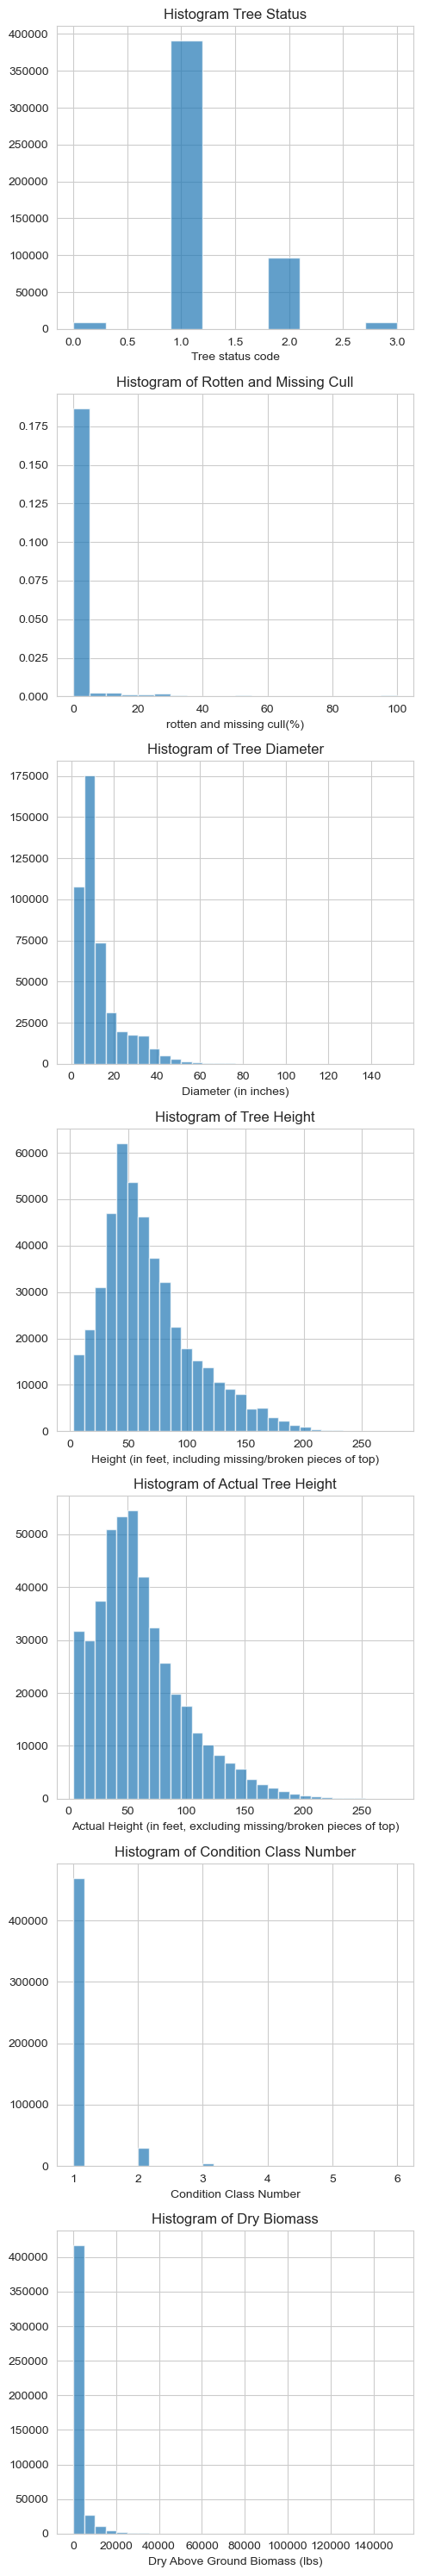

In [83]:
fig, ax = plt.subplots(7, 1, figsize=(5, 30))
ax = np.ravel(ax)

ax[0].hist(WT['STATUSCD'], bins=10, alpha=0.7) 
ax[0].set_xlabel('Tree status code')
ax[0].set_title('Histogram Tree Status')

ax[1].hist(WT['CULL'], bins=20, alpha=0.7,density=True) 
ax[1].set_xlabel('rotten and missing cull(%)')
ax[1].set_title('Histogram of Rotten and Missing Cull')

ax[2].hist(WT['DIA'], bins=30, alpha=0.7) 
ax[2].set_xlabel('Diameter (in inches)')
ax[2].set_title('Histogram of Tree Diameter')

ax[3].hist(WT['HT'], bins=30, alpha=0.7) 
ax[3].set_xlabel('Height (in feet, including missing/broken pieces of top)')
ax[3].set_title('Histogram of Tree Height')

ax[4].hist(WT['ACTUALHT'], bins=30, alpha=0.7) 
ax[4].set_xlabel('Actual Height (in feet, excluding missing/broken pieces of top)')
ax[4].set_title('Histogram of Actual Tree Height')

ax[5].hist(WT['CONDID'], bins=30, alpha=0.7) 
ax[5].set_xlabel('Condition Class Number')
ax[5].set_title('Histogram of Condition Class Number')

ax[6].hist(WT['DRYBIO_AG'], bins=30, alpha=0.7) 
ax[6].set_xlabel('Dry Above Ground Biomass (lbs)')
ax[6].set_title('Histogram of Dry Biomass')

plt.tight_layout()

plt.show()